In [1]:
from __future__ import print_function, division
from IPython.core import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

#If you are running on a server, launch xvfb to record game videos
#Please make sure you have xvfb installed
import os
if os.environ.get("DISPLAY") is str and len(os.environ.get("DISPLAY"))!=0:
    !bash ../xvfb start
    %env DISPLAY=:1
      
#!python3 -m pip install gym[atari]

import numpy as np
import gym
from scipy.misc import imresize
from gym.core import Wrapper
from gym.spaces.box import Box
import cv2



In [2]:
import numpy as np
import gym
from scipy.misc import imresize
from gym.core import Wrapper
from gym.spaces.box import Box

class PreprocessAtari(Wrapper):
    def __init__(self, env, height=42, width=42, color=False, crop=lambda img: img, 
                 n_frames=4, dim_order='theano', reward_scale=1,):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(PreprocessAtari, self).__init__(env)
        assert dim_order in ('theano', 'tensorflow')
        self.img_size = (height, width)
        self.crop=crop
        self.color=color
        self.dim_order = dim_order
        self.reward_scale = reward_scale
        
        n_channels = (3 * n_frames) if color else n_frames
        obs_shape = [n_channels,height,width] if dim_order == 'theano' else [height,width,n_channels]
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')
        
    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer
    
    def step(self,action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward * self.reward_scale, done, info
    
    ### image processing ###
    
    def update_buffer(self,img):
        img = self.preproc_image(img)
        offset = 3 if self.color else 1
        if self.dim_order == 'theano':
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        else:
            axis = -1
            cropped_framebuffer = self.framebuffer[:,:,:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)

    def preproc_image(self, img):
        """what happens to the observation"""
        img = self.crop(img)
        #img = imresize(img, self.img_size)
        img = cv2.resize(img, self.img_size)
        if not self.color:
            img = img.mean(-1, keepdims=True)
        if self.dim_order == 'theano':
            img = img.transpose([2,0,1]) # [h, w, c] to [c, h, w]
        img = img.astype('float32') / 255.
        return img


In [3]:
import gym
#from atari_util import PreprocessAtari


def make_env():
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env, height=81, width=81,
                          crop = lambda img: img[32:-10,8:-8,:],#[60:-30, 5:],
                          dim_order = 'tensorflow',
                          color=False, n_frames=4,
                          reward_scale = 1)
    return env

env = make_env()

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

/home/mew/.local/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Observation shape: (81, 81, 4)
Num actions: 4
Action names: ['NOOP', 'FIRE', 'RIGHT', 'LEFT']


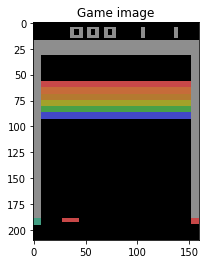

(81, 81, 4)


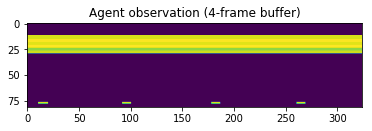

In [4]:
s = env.reset()
for _ in range(100):
  s, _, _, _ = env.step(env.action_space.sample())

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()
print(s.shape)
plt.title('Agent observation (4-frame buffer)')
plt.imshow(s.transpose([0,2,1]).reshape([81,-1]))
plt.show()

In [5]:
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()
import keras as k
from keras.layers import Conv2D, Dense, Flatten, Reshape, LSTM, GRU, TimeDistributed

Using TensorFlow backend.


In [6]:
class Agent:
    def __init__(self, name, state_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""
        
        with tf.variable_scope(name, reuse=reuse):
            self.state_t = tf.placeholder('float32', [1,] + list(state_shape))
            
            
            # Prepare neural network architecture
            ### Your code here: prepare any necessary layers, variables, etc.
            #input_var = tf.placeholder('float32', )
            inputs = k.layers.Input(tensor=self.state_t)
            conv = Conv2D(64,(3,3),strides=3, activation='elu', input_shape = state_shape)(self.state_t)
            conv = Conv2D(128,(3,3),strides=3, activation='elu')(conv)
            conv = Conv2D(256,(3,3),strides=3, activation='elu')(conv)
            conv = Flatten()(conv)
            #conv = Dense(1024, activation='elu')(conv)
            #net.add(Dense(1024, activation='elu'))
            #net.add(k.layers.Dropout(0.1))

            preaction = Dense(256, activation='elu')(conv)
            preqval = Dense(256, activation='elu')(conv)
            
            shared_base = k.layers.Multiply()([preqval, preaction])
            
            
            preqval = k.layers.concatenate([preqval, shared_base])
            preqval = Reshape((1,-1))(preqval)
            preqval = LSTM(64, activation='tanh', recurrent_activation='tanh', return_sequences=True, stateful=True)(preqval)
            preqval = TimeDistributed(Dense(32, activation='elu'))(preqval)
            
            preaction = k.layers.concatenate([shared_base, preaction])
            preaction = k.layers.Reshape((1,-1))(preaction)
            preaction = Dense(128,activation='elu')(preaction)
            preaction = Dense(64,activation='elu')(preaction)
            preaction = Dense(32,activation='elu')(preaction)
            
            preleft = Dense(16, activation='elu')(preqval)
            preright = Dense(16, activation='elu')(preaction)
            premiddle = k.layers.concatenate([preleft, preright])
            premiddle = LSTM(16, activation='tanh', recurrent_activation='tanh', return_sequences=True, stateful=True)(premiddle)
            premiddle = TimeDistributed(Dense(16, activation='elu'))(premiddle)
            
            midqval = k.layers.concatenate([preqval, premiddle])
            midqval = Dense(32, activation='elu')(midqval)
            midqval = LSTM(16, activation='tanh',recurrent_activation='tanh', return_sequences=True, stateful=True)(midqval)
            midqval = TimeDistributed(Dense(32, activation = 'elu'))(midqval)
            
            
            action = k.layers.Multiply()([preaction, midqval])
            action = k.layers.concatenate([premiddle, action])
            action = Dense(128, activation='tanh')(action)
            action = Dense(64, activation='elu')(action)
            action = Dense(64, activation = 'elu')(action)
            action = Dense(32, activation='tanh')(action)
            action = Dense(32, activation='elu')(action)
            action = Dense(n_actions)(action)
            
            middle = k.layers.Multiply()([preaction, preqval])
            middle = k.layers.concatenate([middle, premiddle])
            middle = Dense(32, activation='elu')(middle)
            middle = LSTM(16, activation='tanh', recurrent_activation='tanh', return_sequences=True, stateful=True)(middle)
            middle = TimeDistributed(Dense(16, activation='elu'))(middle)
            
            qval_base = k.layers.concatenate([midqval, action, middle, premiddle, preqval])
            
            rewards = Dense(64, activation='elu')(qval_base)
            rewards_base = LSTM(32, activation='tanh', recurrent_activation='tanh', return_sequences=True, stateful=True)(rewards)
            rewards = Dense(32, activation='tanh')(rewards_base)
            rewards = Dense(16, activation='elu')(rewards)
            rewards = Dense(n_actions)(rewards)
            
            
            
            
            probs_base = k.layers.concatenate([qval_base, rewards_base])
            probs1 = Dense(64, activation='elu')(probs_base)
            probs2 = Dense(64, activation='elu')(probs_base)
            probs1 = Dense(32, activation='tanh')(probs1)
            probs2 = Dense(32, activation = 'tanh')(probs2)
            probs1 = Dense(8, activation ='elu')(probs1)
            probs2 = Dense(8, activation='elu')(probs2)
            probs = k.layers.concatenate([probs1,probs2])
            probs = Dense(n_actions)(probs)
            #probis = k.activations.sigmoid(probs)
            probss = k.layers.Softmax()(probs)
            
            action = k.layers.Multiply()([action, probss])
            qval = k.layers.concatenate([qval_base, action, probs])
            qval = LSTM(64, activation='tanh', recurrent_activation='tanh', return_sequences=True, stateful=True)(qval_base)
            qval = TimeDistributed(Dense(32, activation = 'elu'))(qval)
            
            #qval = k.layers.concatenate([qval, rewardswards])
            
            qval1 = Dense(16, activation='elu')(qval)
            qval2 = Dense(16, activation='elu')(qval)
            qval = k.layers.Multiply()([qval1,qval2])
            qval = Dense(n_actions, activation = 'elu')(qval)
            qval = k.layers.Add()([qval, rewards])
            qval = k.layers.concatenate([probs, qval])
            qval = k.layers.Dense(8, activation='elu')(qval)
            qval = k.layers.Dense(2, activation='elu')(qval)
            
            qval = Dense(1)(qval)
            
            reward = k.layers.Multiply()([rewards, probs])
            reward = Dense(4, activation='elu')(reward)
            reward = Dense(2, activation='elu')(reward)
            reward = Dense(1)(reward)
            
            
            
            
            
            
            
            self.mod = k.models.Model(inputs = self.state_t, outputs=[qval, action, probs, reward])

            # prepare a graph for agent step
            
            self.agent_outputs = self.symbolic_step(self.state_t)
        
    def symbolic_step(self, state_t):
        """Takes agent's previous step and observation, returns next state and whatever it needs to learn (tf tensors)"""
        
        # Apply neural network
        ### Your code here: apply agent's neural network to get policy logits and state values.
        state_value, logits, prob, r = self.mod(state_t)
        prob = prob[:,0,:]
        r = r[:,0,0]
        state_value=state_value[:,0,0]
        logits = logits[:,0,:]
        #probsb = probsb[:,0,:]
        #logits = self.actions(output)[:,0]#output[:,1:]#<logits go here>
        print(logits)
        #state_value = self.qval(output)[:,0,0]#output[:,0]#<state values go here>
        print(state_value)
        assert tf.is_numeric_tensor(state_value) and state_value.shape.ndims == 1, \
            "please return 1D tf tensor of state values [you got %s]" % repr(state_value)
        assert tf.is_numeric_tensor(logits) and logits.shape.ndims == 2, \
            "please return 2d tf tensor of logits [you got %s]" % repr(logits)
        # hint: if you triggered state_values assert with your shape being [None, 1], 
        # just select [:, 0]-th element of state values as new state values
        
        return (logits, state_value, prob, r)
    
    def step(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.agent_outputs, {self.state_t: state_t})
    
    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values, probs, rews = agent_outputs
        policy = np.exp(probs) / np.sum(np.exp(probs), axis=-1, keepdims=True)
        return np.array([np.random.choice(len(p), p=p) for p in policy])

In [7]:
agent = Agent("agent", obs_shape, n_actions)
sess.run(tf.global_variables_initializer())

Tensor("agent/strided_slice_3:0", shape=(1, 4), dtype=float32)
Tensor("agent/strided_slice_2:0", shape=(1,), dtype=float32)


In [8]:
state = [env.reset()]
logits, value, probs, rews = agent.step(state)
print("action logits:\n", logits)
print("state values:\n", value)

action logits:
 [[ 3.1084885e-06 -1.1674704e-06 -1.3718098e-06  6.3967841e-06]]
state values:
 [-8.652793e-06]


In [9]:
def evaluate(agent, env, n_games=1):
    """Plays an a game from start till done, returns per-game rewards """

    game_rewards = []
    for _ in range(n_games):
        state = env.reset()
        
        total_reward = 0
        while True:
            action = agent.sample_actions(agent.step([state]))[0]
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done: break
                
        game_rewards.append(total_reward)
    return game_rewards


In [10]:
env_monitor = gym.wrappers.Monitor(env, directory="kung10", force=True)
rw = evaluate(agent, env_monitor, n_games=3,)
env_monitor.close()
print (rw)

[1.0, 0.0, 2.0]


In [11]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./kung10/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kung10/"+video_names[-1])) #this may or may not be _last_ video. Try other indices



In [12]:
class EnvBatch:
    def __init__(self, n_envs = 10):
        """ Creates n_envs environments and babysits them for ya' """
        self.envs = [make_env() for _ in range(n_envs)]
        self.old_infos = None
        
    def reset(self):
        """ Reset all games and return [n_envs, *obs_shape] observations """
        print(len(self.envs))
        return np.array([env.reset() for env in self.envs])
    
    def step(self, actions):
        """
        Send a vector[batch_size] of actions into respective environments
        :returns: observations[n_envs, *obs_shape], rewards[n_envs], done[n_envs,], info[n_envs]
        """
        results = [env.step(a) for env, a in zip(self.envs, actions)]
        #print(results)
        new_obs, rewards, done, infos = map(np.array, zip(*results))
        if self.old_infos is not None:
            for i in range(len(infos)):
                if infos[i]['ale.lives']< self.old_infos[i]['ale.lives']:
                    rewards[i] = -20
        self.old_infos = infos
        # reset environments automatically
        for i in range(len(self.envs)):
            if done[i]:
                new_obs[i] = self.envs[i].reset()
        
        return new_obs, rewards, done, infos

In [13]:
env_batch = EnvBatch(1)

batch_states = env_batch.reset()

batch_actions = agent.sample_actions(agent.step(batch_states))

batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)
print("State shape:", batch_states.shape)
print("Actions:", batch_actions[:3])
print("Rewards:", batch_rewards[:3])
print("Done:", batch_done[:3])


/home/mew/.local/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
1
State shape: (1, 81, 81, 4)
Actions: [3]
Rewards: [0.]
Done: [False]


In [14]:
# These placeholders mean exactly the same as in "Let's try it out" section above
states_ph = tf.placeholder('float32', [None,] + list(obs_shape))    
next_states_ph = tf.placeholder('float32', [None,] + list(obs_shape))
actions_ph = tf.placeholder('int32', (None,))
rewards_ph = tf.placeholder('float32', (None,))
is_done_ph = tf.placeholder('float32', (None,))
agent_probs = tf.placeholder('float32', [None, n_actions])
agent_rewards = tf.placeholder('float32', [None, n_actions])

In [15]:
# logits[n_envs, n_actions] and state_values[n_envs, n_actions]
logits, state_values, agent_probs, _ = agent.symbolic_step(states_ph)
next_logits, next_state_values, _, agent_reward = agent.symbolic_step(next_states_ph)
next_state_values = next_state_values * (1 - is_done_ph)

# probabilities and log-probabilities for all actions
probs = tf.nn.softmax(logits)            # [n_envs, n_actions]
logprobs = tf.nn.log_softmax(logits)     # [n_envs, n_actions]
agent_logprobs = tf.nn.log_softmax(agent_probs)
agent_probs = tf.nn.softmax(agent_probs)
agent_logp = tf.reduce_sum(agent_logprobs * tf.one_hot(actions_ph, n_actions), axis=-1) # [n_envs,]
# log-probabilities only for agent's chosen actions
logp_actions = tf.reduce_sum(logprobs * tf.one_hot(actions_ph, n_actions), axis=-1) # [n_envs,]

Tensor("strided_slice_3:0", shape=(1, 4), dtype=float32)
Tensor("strided_slice_2:0", shape=(1,), dtype=float32)
Tensor("strided_slice_7:0", shape=(1, 4), dtype=float32)
Tensor("strided_slice_6:0", shape=(1,), dtype=float32)


In [16]:


# compute advantage using rewards_ph, state_values and next_state_values
gamma = 0.99
advantage = rewards_ph + gamma * next_state_values - state_values

assert advantage.shape.ndims == 1, "please compute advantage for each sample, vector of shape [n_envs,]"

# compute policy entropy given logits_seq. Mind the "-" sign!
print(probs)
entropy = - tf.reduce_sum(agent_probs*agent_logprobs, axis=-1) - tf.reduce_sum(probs*logprobs, axis=-1)
print(entropy)
assert entropy.shape.ndims == 1, "please compute pointwise entropy vector of shape [n_envs,] "

decay = 0.999
mul = 0.009

#actor_loss =  - tf.reduce_mean(agent_logp * tf.stop_gradient(advantage)) - mul * tf.reduce_mean(entropy)
actor_loss =  - tf.reduce_mean(agent_logp * tf.stop_gradient(advantage)) - tf.reduce_mean(logp_actions * tf.stop_gradient(advantage)) - mul *  tf.reduce_mean(entropy)
#actor_loss =   tf.reduce_mean(entropy)
# compute target state values using temporal difference formula. Use rewards_ph and next_step_values
target_state_values = rewards_ph + gamma*next_state_values
#critic_loss = tf.reduce_mean(state_values-state_values)
critic_loss = tf.reduce_mean((state_values - tf.stop_gradient(target_state_values))**2 )# - tf.reduce_mean(state_values)*0.001 
critic_loss = critic_loss + tf.reduce_mean(k.losses.binary_crossentropy(tf.stop_gradient(probs), agent_probs))
critic_loss = critic_loss + tf.reduce_mean((agent_reward - tf.stop_gradient(rewards_ph))**2)
optimizer = tf.train.AdamOptimizer(5e-5)
gradients, variables = zip(*optimizer.compute_gradients(actor_loss))# + critic_loss))
gradients, _ = tf.clip_by_global_norm(gradients, 2.0)
train_step = optimizer.apply_gradients(zip(gradients, variables))
sess.run(tf.global_variables_initializer())

Tensor("Softmax:0", shape=(1, 4), dtype=float32)
Tensor("sub_2:0", shape=(1,), dtype=float32)


In [17]:
# Sanity checks to catch some errors. Specific to KungFuMaster in assignment's default setup.
l_act, l_crit, adv, ent = sess.run([actor_loss, critic_loss, advantage, entropy], feed_dict = {
        states_ph: batch_states,
        actions_ph: batch_actions,
        next_states_ph: batch_states,
        rewards_ph: batch_rewards,
        is_done_ph: batch_done,
    })

assert abs(l_act) < 100 and abs(l_crit) < 100, "losses seem abnormally large"
#assert 0 <= ent.mean() <= np.log(n_actions), "impossible entropy value, double-check the formula pls"
if ent.mean() < np.log(n_actions) / 2: print("Entropy is too low for untrained agent")
print("You just might be fine!")

You just might be fine!


In [ ]:
from IPython.display import clear_output
from tqdm import trange
from pandas import DataFrame
ewma = lambda x, span=100: DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

env_batch = EnvBatch(1)
batch_states = env_batch.reset()

rewards_history = []
entropy_history = []

/home/mew/.local/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
1


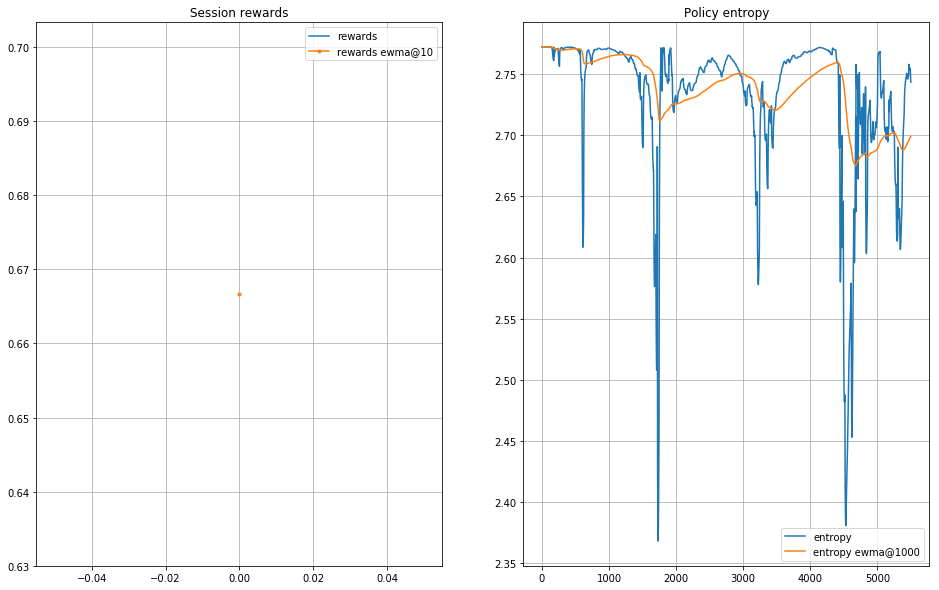

  0%|          | 5835/5000000 [05:27<80:21:53, 17.26it/s] 

In [ ]:
for i in trange(5000000): 
    
    batch_actions = agent.sample_actions(agent.step(batch_states))
    batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)
    
    feed_dict = {
        states_ph: batch_states,
        actions_ph: batch_actions,
        next_states_ph: batch_next_states,
        rewards_ph: batch_rewards,
        is_done_ph: batch_done,
    }
    if batch_done[0] > 0.5:
        agent.mod.reset_states()
    batch_states = batch_next_states
    if mul >= 0.000005:
        mul *= decay
    _, ent_t = sess.run([train_step, entropy], feed_dict)
    entropy_history.append(np.mean(ent_t))

    if i % 500 == 0: 
        if i % 10000 == 0:
            rewards_history.append(np.mean(evaluate(agent, env, n_games=3)))
            if rewards_history[-1] >= 50:
                print("Your agent has earned the yellow belt")# % color)

        clear_output(True)
        plt.figure(figsize=[16,10])
        plt.subplot(1,2,1)
        plt.plot(rewards_history, label='rewards')
        plt.plot(ewma(np.array(rewards_history),span=10), marker='.', label='rewards ewma@10')
        plt.title("Session rewards"); plt.grid(); plt.legend()
        
        plt.subplot(1,2,2)
        plt.plot(entropy_history, label='entropy')
        plt.plot(ewma(np.array(entropy_history),span=1000), label='entropy ewma@1000')
        plt.title("Policy entropy"); plt.grid(); plt.legend()        
        plt.show()
        
        

